In [1]:
# Install dependencies
!pip install -q -r requirements.txt

In [2]:
import os
import pandas as pd
import numpy as np
import notebook_utils.notebook_helpers as utils
import cudf
from cuopt.routing import DataModel, SolverSettings, Solve

# Service Team Routing
## Capacitated Vehicle Routing Problem with Time Windows (CVRPTW)

The ability of service providers to set service time windows allows for easier and more dependable coordination between the service provider and their customers, while increasing overall customer satisfaction.

In this scenario we have a number of service order locations with associated time windows and service times (time on-site to complete service). Each technician has an associated availability, ability to complete certain types of service, and a maximum number of service appointments per day.

### Problem Details:
- 8 Locations each with an associated demand
    - 1 Headquarters 
        - service type 1 demand: [0]
        - service type 2 demand: [1]
        - headquarters hours of operation: [5,20]
    - 7 Service Locations
        - service type 1 demand: [1, 1, 1, 0, 0, 0, 0]
        - service type 2 demand: [0, 0, 1, 1, 1, 1, 1]
        - service locations time windows: [[9,12],[9,12],[11,14],[13,16],[13,16],[13,16],[13,16]]
        - service location service times: [ 1, 1, 1.5, 0.5, 0.5, 0.5]

- 3 Delivery vehicles each with an associated capacity
    - 3 service technicians
        - capacity for service type 1: [2, 1, 0]
        - capacity for service type 2: [0, 1, 4]
        - technician availability [[9,17], [12,15], [9,17]]
        

Below we visualize the service locations with respect to the service company headquarters. The cost from all locations to all other locations (a cost matrix) will be required for optimization. To see an example of cost matrix generation from map data or a waypoint graph, refer to the [cost_matrix_creation.ipynb](cost_matrix_creation.ipynb) notebook.  For the purpose of this simple example we will omit the cost matrix calculation.

/home/nfs/aanandh/cuoptres/last_mile_delivery/notebook_utils/notebook_helpers.py:68: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  (df["xcord"][i], df["ycord"][i]),


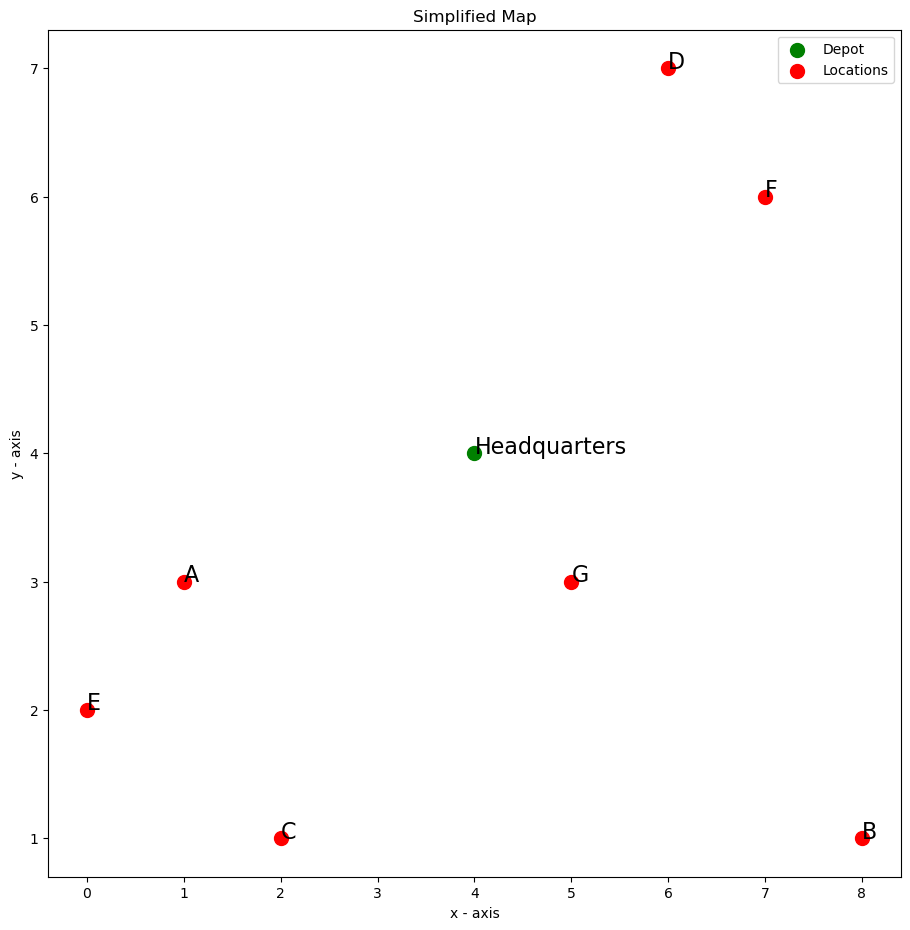

In [3]:
location_names       = [ "Headquarters",     "A",    "B",    "C",    "D",    "E",    "F",    "G"  ]
location_coordinates = [     [4, 4],        [1, 3], [8, 1], [2, 1], [6, 7], [0, 2], [7, 6], [5, 3] ]
location_coordinates_df = pd.DataFrame(location_coordinates, columns=['xcord', 'ycord'], index=location_names)
utils.gen_plot(location_coordinates_df).show()

### Cost Matrix

The cost matrix dictates the cost of travel between locations of interest.  The cost itself can be anything relevant to the user.  In this case we are constraining time window constraints.  When constraining time windows for locations or vehicles it is assumed (if only a single cost matrix is provided) that it represents time. 

Here is the cost(time) matrix corresponding to the locations above:

In [4]:
time_matrix = [
 [0.00, 0.31, 0.50, 0.36, 0.36, 0.44, 0.36, 0.14],
 [0.31, 0.00, 0.72, 0.22, 0.64, 0.14, 0.67, 0.40],
 [0.50, 0.72, 0.00, 0.60, 0.63, 0.80, 0.51, 0.36],
 [0.36, 0.22, 0.60, 0.00, 0.72, 0.22, 0.70, 0.36],
 [0.36, 0.64, 0.63, 0.72, 0.00, 0.77, 0.14, 0.41],
 [0.44, 0.14, 0.80, 0.22, 0.77, 0.00, 0.80, 0.51],
 [0.36, 0.67, 0.51, 0.70, 0.14, 0.80, 0.00, 0.36],
 [0.14, 0.40, 0.36, 0.36, 0.41, 0.51, 0.36, 0.00]
]

# Create a dataframe of this matrix
time_matrix_df  = pd.DataFrame(time_matrix, 
                              index=location_coordinates_df.index, 
                              columns=location_coordinates_df.index)
time_matrix_df

,Headquarters,A,B,C,D,E,F,G
Headquarters,0.00,0.31,0.50,0.36,0.36,0.44,0.36,0.14
A,0.31,0.00,0.72,0.22,0.64,0.14,0.67,0.40
B,0.50,0.72,0.00,0.60,0.63,0.80,0.51,0.36
C,0.36,0.22,0.60,0.00,0.72,0.22,0.70,0.36
D,0.36,0.64,0.63,0.72,0.00,0.77,0.14,0.41
E,0.44,0.14,0.80,0.22,0.77,0.00,0.80,0.51
F,0.36,0.67,0.51,0.70,0.14,0.80,0.00,0.36
G,0.14,0.40,0.36,0.36,0.41,0.51,0.36,0.00


### Service Locations

Setup the service location data

In [5]:
# exclude head quarters from service location names
service_location_ids = [1, 2, 3, 4, 5, 6, 7]
service_location_names = [location_names[i] for i in service_location_ids]
service_location_data = {
    "service_location_names": service_location_names,
    "service_location_ids": service_location_ids,
    "service_type1_demand": [1, 1, 1, 0, 0, 0, 0],
    "service_type2_demand": [0, 0, 1, 1, 1, 1, 1],
    "location_earliest_time": [9, 9, 11, 13, 13, 13, 13],
    "location_latest_time": [12, 12, 14, 16, 16, 16,16],
    "required_service_time": [1, 1, 1, 0, 0, 0, 0]
}
service_location_data_df = pd.DataFrame(service_location_data).set_index('service_location_names')
service_location_data_df

,service_location_ids,service_type1_demand,service_type2_demand,location_earliest_time,location_latest_time,required_service_time
service_location_names,,,,,,
A,1,1,0,9,12,1
B,2,1,0,9,12,1
C,3,1,1,11,14,1
D,4,0,1,13,16,0
E,5,0,1,13,16,0
F,6,0,1,13,16,0
G,7,0,1,13,16,0


### Vehicles

Setup vehicle/technician data

In [6]:
n_vehicles = 3
vehicle_data = {
    "vehicle_ids": [i for i in range(n_vehicles)],
    "capacity_service_type1":[2, 1, 0],
    "capacity_service_type2":[0, 1, 4],
    "vehicle_availability_earliest":[9, 11, 9],
    "vehicle_availability_latest":[17, 15, 17]
}
vehicle_data_df = pd.DataFrame(vehicle_data).set_index('vehicle_ids')
vehicle_data_df

,capacity_service_type1,capacity_service_type2,vehicle_availability_earliest,vehicle_availability_latest
vehicle_ids,,,,
0,2,0,9,17
1,1,1,11,15
2,0,4,9,17


# Initialize cuOpt Problem Data Using Python API

In [7]:
# Create DataModel
# Params: num_locations, num_vehicles, num_orders
n_locations = len(location_names)
n_orders = len(service_location_ids)
data_model = DataModel(n_locations, n_vehicles, n_orders)

### Set Cost Matrix

In [8]:
# Convert the time matrix to cuDF DataFrame
cost_matrix = cudf.DataFrame(time_matrix).astype(np.float32)
data_model.add_cost_matrix(cost_matrix)

### Set Order Locations and Properties

In [9]:
# Set order locations
data_model.set_order_locations(cudf.Series(service_location_ids))

# Set order time windows
order_earliest = cudf.Series(service_location_data["location_earliest_time"]).astype(np.int32)
order_latest = cudf.Series(service_location_data["location_latest_time"]).astype(np.int32)
data_model.set_order_time_windows(order_earliest, order_latest)

# Set order service times
service_times = cudf.Series(service_location_data["required_service_time"]).astype(np.int32)
data_model.set_order_service_times(service_times)

### Set Vehicle Data

In [10]:
# Set vehicle time windows
vehicle_earliest = cudf.Series(vehicle_data["vehicle_availability_earliest"]).astype(np.int32)
vehicle_latest = cudf.Series(vehicle_data["vehicle_availability_latest"]).astype(np.int32)
data_model.set_vehicle_time_windows(vehicle_earliest, vehicle_latest)

# Add capacity dimensions for service types
service_type1_demand = cudf.Series(service_location_data["service_type1_demand"]).astype(np.int32)
service_type1_capacity = cudf.Series(vehicle_data["capacity_service_type1"]).astype(np.int32)
data_model.add_capacity_dimension("service_type1", service_type1_demand, service_type1_capacity)

service_type2_demand = cudf.Series(service_location_data["service_type2_demand"]).astype(np.int32)
service_type2_capacity = cudf.Series(vehicle_data["capacity_service_type2"]).astype(np.int32)
data_model.add_capacity_dimension("service_type2", service_type2_demand, service_type2_capacity)

### Set Solver Configuration

In [11]:
# Create solver settings
solver_settings = SolverSettings()
solver_settings.set_time_limit(5)

### Get Optimized Routes

In [13]:
# Solve the problem
solution = Solve(data_model, solver_settings)

if solution.get_status() == 0:  # Success
    print("Cost for the routing in distance: ", solution.get_total_objective())
    print("Vehicle count to complete routing: ", solution.get_vehicle_count())
    
    # Get routes
    routes = solution.get_route()
    
    # Display routes
    utils.show_vehicle_routes(solution, location_names)
else:
    print("NVIDIA cuOpt Failed to find a solution with status : ", solution.get_status())

Cost for the routing in distance:  4.060000076889992
Vehicle count to complete routing:  3
For vehicle 0 route is:
Headquarters → Headquarters → A → Headquarters

For vehicle 2 route is:
Headquarters → D → F → E → C → Headquarters

For vehicle 1 route is:
Headquarters → B → Headquarters



**Notice** that this solution leverages the fact that vehicle 1 is the only vehicle with the ability to perform both service type 1 and service type 2.  In addition, vehicle 0 and vehicle 2 also serve the locations they are suited to service and minimize the time taken along these routes.

AttributeError: 'dict' object has no attribute 'get_route'

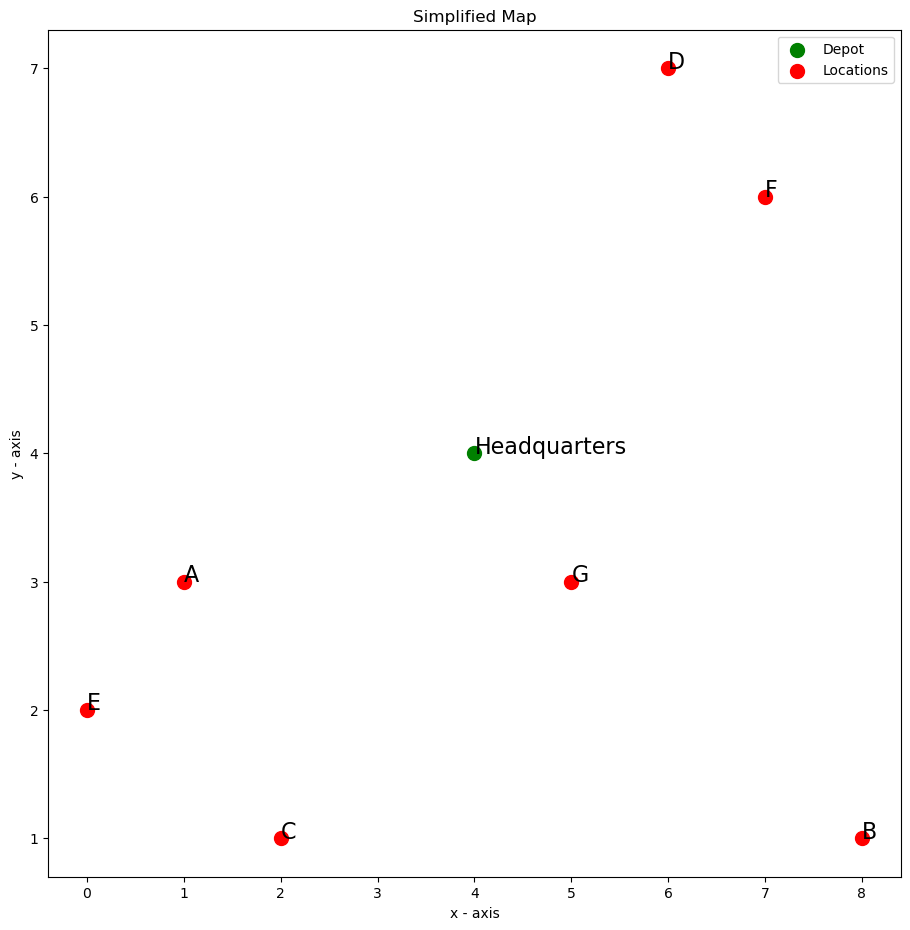

In [ ]:
vehicle_colors = ["red", "green", "blue"]
utils.map_vehicle_routes(location_coordinates_df, solution, vehicle_colors).show()


SPDX-FileCopyrightText: Copyright (c) 2024 NVIDIA CORPORATION & AFFILIATES. All rights reserved.
SPDX-License-Identifier: MIT
Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions: The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.